In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)

from libs.lib import *

c:\Users\PC\Data\ads_prj_nckh


In [2]:
exps_dir = "../../exps/exp1"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/Standard_Label/class_dict_weight_SMOTE/data"
os.makedirs(save_dir, exist_ok=True)

test_size=0.33
seed=42

In [3]:
feature_selection=dict(np.load(f'{save_dir}/feature_model_selection.npz',allow_pickle=True))['feature_model_selection']
feature_selection = {key: value for key, value in feature_selection.item().items()}
feature_selection

{'LR': ['AccidentArea',
  'Age',
  'AgeOfVehicle',
  'AgentType',
  'BasePolicy',
  'Deductible',
  'DriverRating',
  'Fault',
  'MaritalStatus',
  'NumberOfCars',
  'PoliceReportFiled',
  'PolicyType',
  'Sex',
  'VehicleCategory',
  'WitnessPresent'],
 'LDA': ['AccidentArea',
  'Age',
  'AgeOfVehicle',
  'AgentType',
  'BasePolicy',
  'Deductible',
  'DriverRating',
  'Fault',
  'MaritalStatus',
  'NumberOfCars',
  'PoliceReportFiled',
  'PolicyType',
  'Sex',
  'VehicleCategory',
  'WitnessPresent'],
 'DTC': ['AccidentArea',
  'Age',
  'AgeOfVehicle',
  'BasePolicy',
  'DriverRating',
  'Fault',
  'Make',
  'MaritalStatus',
  'Month',
  'MonthClaimed',
  'NumberOfSuppliments',
  'PastNumberOfClaims',
  'Sex',
  'VehicleCategory',
  'VehiclePrice'],
 'RD': ['AccidentArea',
  'Age',
  'AgeOfVehicle',
  'BasePolicy',
  'DriverRating',
  'Fault',
  'Make',
  'MaritalStatus',
  'Month',
  'MonthClaimed',
  'NumberOfSuppliments',
  'PastNumberOfClaims',
  'PolicyType',
  'VehicleCategory'

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [4]:
bg_model=joblib.load(f'{save_dir}/bg_model.joblib')
rf_model=joblib.load(f'{save_dir}/rf_model.joblib')
svm_model=joblib.load(f'{save_dir}/svm_model.joblib')

In [5]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{save_dir}/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 0.5317035512094699, 1: 8.385551948051948}

In [6]:


# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    encoder = OneHotEncoder(sparse=False)
    
    labels_reshaped = labels.reshape(-1, 1)
    
    encoder.fit(labels_reshaped)
    
    onehot_labels = encoder.transform(labels_reshaped)
    # onehot_labels=pd.DataFrame(onehot_labels)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)
print(y_test_onehot.shape,y_train_onehot.shape)


(5089, 2) (19430, 2)


In [7]:
y_test_onehot.reshape(-1, 1)
print(y_test_onehot.shape)

(5089, 2)


In [8]:
x_test.shape

(5089, 34)

In [9]:
x_train.shape

(19430, 34)

In [10]:
def f1_score(y_true, y_pred):
    """
    Macro F1 score metric.
    """
    # Convert predictions to binary (0 or 1)
    y_pred = K.round(y_pred)
    
    # Calculate True Positives, False Positives and False Negatives for each class
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)
    
    # Calculate precision and recall for each class
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())
    
    # Calculate F1 score for each class
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    # Calculate macro F1 score
    macro_f1_score = K.mean(f1_scores)
    
    return macro_f1_score

In [11]:
print(x_train.shape[1])

34


#### * Xây dựng model:

In [12]:

early_stopping = EarlyStopping(monitor='f1_score',
                                mode='max',
    min_delta=0.00005,
    patience=100,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='f1_score',
    mode='max',
    factor=0.5,
    patience=10,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',  # Đường dẫn để lưu model
    monitor='f1_score',  # Theo dõi val_loss
    mode='max',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1  # Hiển thị thông báo khi lưu model
)



In [13]:
# best_model.save_weights('weights.h5')


In [14]:
# best_trials = tuner.oracle.get_best_trials(1)[0].hyperparameters.values
# best_trials

#### * Xây dựng Stacked_model:

In [15]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from keras.models import Sequential
# from keras.layers import Dense, BatchNormalization, Dropout
# from sklearn.metrics import accuracy_score
# import numpy as np
# from tensorflow.keras.optimizers import Adam
# tabnet_params = {
#     "decision_dim": 16,
#     "attention_dim": 16,
#     "n_steps": 3,
#     "n_shared_glus": 2,
#     "n_dependent_glus": 2,
#     "relaxation_factor": 1.3,
#     "epsilon": 1e-15,
#     "momentum": 0.98,
#     "mask_type": "softmax", # can be 'sparsemax' or 'softmax'
#     "lambda_sparse": 1e-3, 
#     "virtual_batch_splits": 8 #number of splits for ghost batch normalization, ideally should evenly divide the batch_size
# }

# # Hàm để xây dựng mô hình đầu ra
# def model_output(tabnet_params):
#     # model.load_weights('best_tabnet_model.h5')
#     learning_rate=0.1
#     ### Classification
#     model = TabNetClassifier(n_classes = 1, out_activation = 'sigmoid', **tabnet_params)
#     # model = TabNetClassifier(n_classes = 2, out_activation = 'softmax', 
#     #     kernel_regularizer=l2(0.01), **tabnet_params)
#     # model.compile(loss = 'categorical_crossentropy', optimizer = )
#     # model.fit(x_train, y_train, epochs = 100, batch_size = 1024)
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
#     # model.compile(optimizer=Adam(lr=learning_rate), loss=f1_loss, metrics=['accuracy',f1_score])
#     # model.compile(optimizer=Adam(lr=learning_rate), loss=focal_loss, metrics=['accuracy',f1_score])
#     # model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_9cat_loss, metrics=['accuracy',f1_score])
#     return model




In [16]:
# # model.load_weights('best_tabnet_model.h5')
# learning_rate=0.1
# ### Classification
# model = TabNetClassifier(n_classes = 1, out_activation = 'sigmoid', **tabnet_params)
# # model = TabNetClassifier(n_classes = 2, out_activation = 'softmax', 
# #     kernel_regularizer=l2(0.01), **tabnet_params)
# # model.compile(loss = 'categorical_crossentropy', optimizer = )
# # model.fit(x_train, y_train, epochs = 100, batch_size = 1024)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
# # model.summary()

#### * Sử dụng Stacking để kết hợp dự đoán của các mô hình cơ sở để tạo ra một mô hình cuối cùng:

In [17]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import tensorflow as tf
from tabnet_keras import TabNetClassifier

class TabNetWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.kwargs = kwargs

    def fit(self, X, y):
        self.model = TabNetClassifier(n_classes = 1, out_activation = 'sigmoid',**self.kwargs)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy',f1_score])

        self.model.fit(X, y, epochs=10, batch_size=64, class_weight=class_weights_dict)
        return self

    def predict(self, X):
        proba = self.model.predict(X)
        return (proba > 0.5).astype(int)

    def predict_proba(self, X):
        return self.model.predict(X)
    
    def summary(self):
        return self.model.summary()

In [18]:
tabnet_params = {
    "decision_dim": 16,
    "attention_dim": 16,
    "n_steps": 3,
    "n_shared_glus": 2,
    "n_dependent_glus": 2,
    "relaxation_factor": 1.3,
    "epsilon": 1e-15,
    "momentum": 0.98,
    "mask_type": "softmax", # can be 'sparsemax' or 'softmax'
    "lambda_sparse": 1e-3, 
    "virtual_batch_splits": 8 #number of splits for ghost batch normalization, ideally should evenly divide the batch_size
}
tabnet = TabNetWrapper(**tabnet_params)


In [19]:
from sklearn.ensemble import StackingClassifier

# def create_keras_model():
#     # Thêm các lớp khác vào đây
#     best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_score])
#     best_model.load_weights('weights.h5')
#     return best_model

# tabnet = KerasClassifier(build_fn=create_keras_model, epochs=10)

# rf_model=RandomForestClassifier(n_estimators=100, random_state=seed)
# bg_model=GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=seed)
# svm_model=SVC(kernel='rbf',probability=True, gamma='scale' , random_state=seed)

# Huấn luyện các mô hình cơ sở
rf_model.fit(x_train, y_train)
bg_model.fit(x_train, y_train)
svm_model.fit(x_train, y_train)


# Dự đoán đầu ra của các mô hình cơ sở
rf_pred = rf_model.predict(x_test)
svm_pred = svm_model.predict(x_test)
bg_pred = bg_model.predict(x_test)


# keras_pred = tabnet.predict(x_test)
stacked_input = np.column_stack((rf_pred,svm_pred,bg_pred))


#history=model.fit(x=x_train,y=y_train,
          #validation_data=(x_test,y_test),class_weight=class_weights_dict ,
          #batch_size=64,epochs=120, callbacks=[confusion_matrix_callback])

# tabnet = KerasClassifier(build_fn=model_output, tabnet_params=tabnet_params,batch_size=64,epochs=10000,callbacks=[early_stopping,lr_scheduler])

# Clone lại để tránh thay đổi trực tiếp vào mô hình gốc
# tabnet = clone(tabnet)
# Xây dựng mô hình stacking
stacked_model = StackingClassifier(
    estimators=[('rf',rf_model), ('svm',svm_model),('bg',bg_model)],
    final_estimator=tabnet
)
print(stacked_input.shape)
print(y_test.shape)
# Tiếp tục với việc huấn luyện và đánh giá mô hình stacking
stacked_model.fit(stacked_input, y_test)
stacked_pred = stacked_model.predict(stacked_input)
# stacked_pred

(5089, 3)
(5089, 1)
Epoch 1/10
80/80 [==============================] - 4s 3ms/step - loss: 0.8147 - accuracy: 0.6661 - f1_score: 0.1101
Epoch 2/10
80/80 [==============================] - 0s 2ms/step - loss: 0.7011 - accuracy: 0.7253 - f1_score: 0.1696
Epoch 3/10
80/80 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.7524 - f1_score: 0.2063
Epoch 4/10
80/80 [==============================] - 0s 2ms/step - loss: 0.6495 - accuracy: 0.7825 - f1_score: 0.2610
Epoch 5/10
80/80 [==============================] - 0s 2ms/step - loss: 0.6375 - accuracy: 0.8043 - f1_score: 0.2735
Epoch 6/10
80/80 [==============================] - 0s 2ms/step - loss: 0.6262 - accuracy: 0.8169 - f1_score: 0.3008
Epoch 7/10
80/80 [==============================] - 0s 3ms/step - loss: 0.6035 - accuracy: 0.8630 - f1_score: 0.3315
Epoch 8/10
80/80 [==============================] - 0s 3ms/step - loss: 0.5995 - accuracy: 0.8567 - f1_score: 0.3389
Epoch 9/10
80/80 [==========================

In [20]:
# stacked_model.fit(stacked_input, y_test)
# Dự đoán và đánh giá mô hình stacked
stacked_pred = stacked_model.predict(stacked_input)
stacked_pred_labels = (stacked_pred > 0.5).astype(int)
accuracy_stacked = accuracy_score(y_test, stacked_pred_labels)
print(f'Accuracy of Stacked Model: {accuracy_stacked}')

160/160 [==============================] - 0s 748us/step
Accuracy of Stacked Model: 0.9078404401650619


#### * Kết quả đánh giá mô hình:

In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, stacked_pred_labels)
print("Accuracy:", accuracy)

# Hiển thị báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, stacked_pred_labels,labels=[1,0]))

# # Hiển thị ma trận nhầm lẫn
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.9078404401650619
Classification Report:
              precision    recall  f1-score   support

           1       0.33      0.52      0.40       307
           0       0.97      0.93      0.95      4782

    accuracy                           0.91      5089
   macro avg       0.65      0.73      0.68      5089
weighted avg       0.93      0.91      0.92      5089



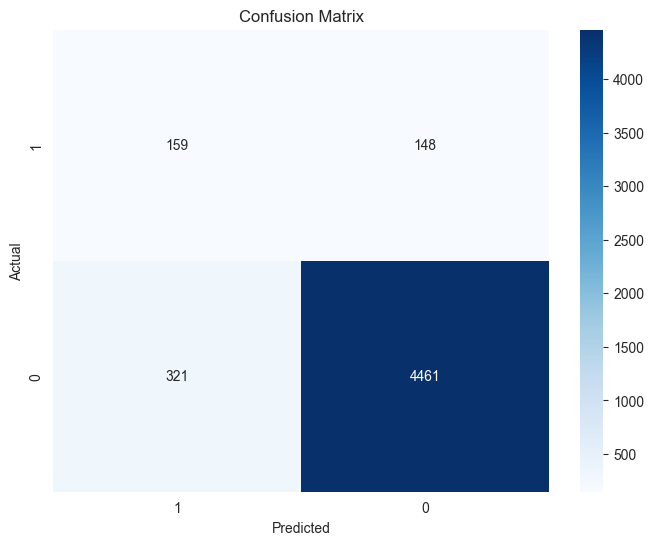

In [22]:
# Dự đoán


# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, stacked_pred_labels,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

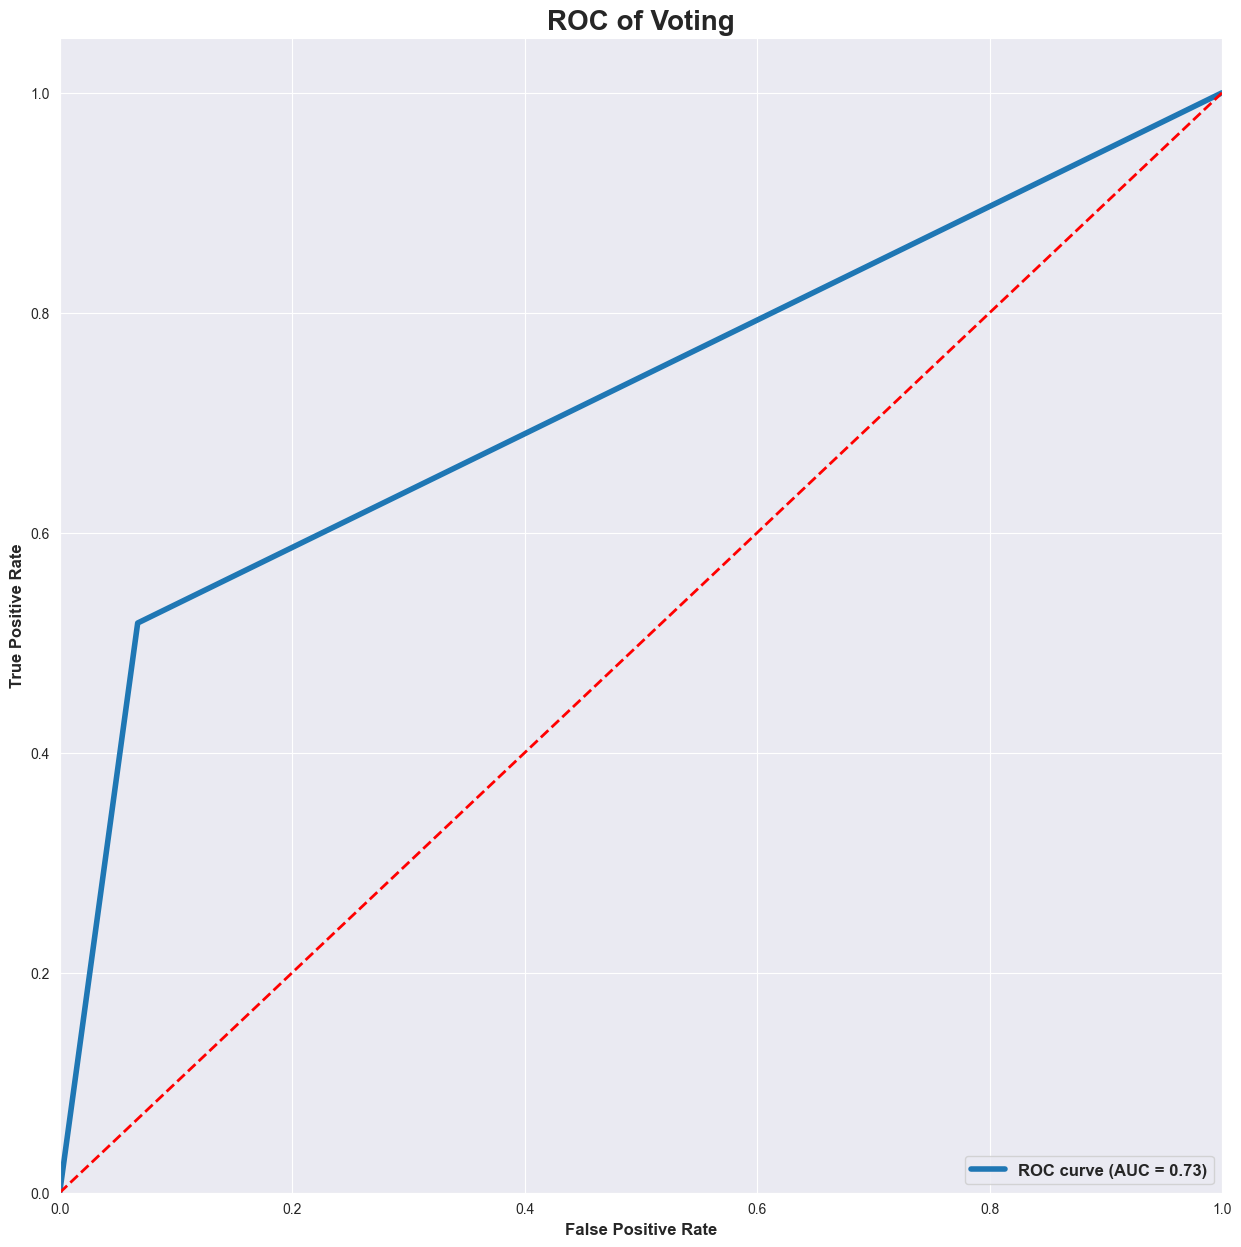

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

fpr, tpr, _ = roc_curve(y_test, stacked_pred)
    
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   
ax.set_title(f'ROC of Voting',fontsize=20, weight='bold')  
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'}) 
plt.show()

In [24]:
def check_result(prediction):
    prediction = (prediction > 0.5).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [25]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = stacked_model.predict(stacked_input)
    stacked_pred_labels = y_predict.argmax(axis=1)

    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(stacked_pred_labels[indx]))
    print("----------------------------")
    if Y_check==check_result(stacked_pred_labels[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1
    

160/160 [==============================] - 0s 755us/step


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


Số lần dự đoán đúng: 275 chiếm khoảng 83.33333333333334% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 75 chiếm khoảng 85.22727272727273% so với thực tế
